# Seasonal Autoregressive Integrated Moving Average with Explanatory Variable (SARIMAX)

The <a href="https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average">ARIMA</a> model is a generalisation of an ARMA model that can be applied to non-stationary time series.

The SARIMAX model is an modified and extended version of ARIMA that accounts for seasonality in the time series and includes independent predictor variables.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
matplotlib.rcParams['figure.figsize'] = (16, 9)
pd.options.display.max_columns = 999

## Load Dataset

In [3]:
df = pd.read_csv('../datasets/hourly-weather-temperature.csv', parse_dates=[0], index_col='DateTime')
print(df.shape)
df.head()

(5000, 36)


,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,ts11,ts12,ts13,ts14,ts15,ts16,ts17,ts18,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28,ts29,ts30,ts31,ts32,ts33,ts34,ts35,ts36
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-25 01:00:00,282.75,284.44,287.37,283.15,291.65,290.82,296.72,297.87,291.35,283.54,298.31,297.59,296.60,289.66,277.90,295.29,283.94,294.67,293.20,294.48,291.20,293.32,290.43,296.15,293.03,280.57,284.09,283.98,272.76,279.11,280.356,285.15,284.706,291.056,291.056,285.15
2017-03-25 02:00:00,282.18,283.30,287.21,282.15,290.89,290.15,296.13,297.00,289.14,281.72,295.89,295.53,296.88,288.65,277.42,294.29,279.83,293.67,292.44,293.75,287.14,293.35,288.88,296.04,292.54,279.42,283.17,282.70,272.47,279.34,279.539,285.15,290.150,291.039,291.039,285.15
2017-03-25 03:00:00,281.50,282.58,286.75,281.77,289.29,289.43,294.72,296.32,288.15,279.15,290.44,294.95,295.97,288.17,277.02,293.58,279.57,293.41,291.91,292.84,284.62,292.32,287.32,295.82,291.74,277.86,281.89,282.67,272.46,279.80,279.539,285.15,283.489,291.039,291.039,285.15
2017-03-25 04:00:00,280.83,282.15,286.52,281.26,288.48,288.33,293.52,294.48,286.55,277.30,288.30,294.28,294.79,287.80,276.82,293.17,279.06,292.65,291.88,292.35,280.70,292.34,286.67,295.65,291.02,277.33,281.24,281.60,272.15,279.90,279.539,285.71,288.150,286.150,286.150,285.76
2017-03-25 05:00:00,280.17,282.15,286.07,280.93,287.91,287.60,293.34,292.02,285.56,276.30,287.57,293.42,293.87,287.30,276.68,292.46,278.77,291.65,290.56,291.59,280.56,291.35,286.88,295.87,290.16,276.88,280.38,281.01,272.15,279.74,285.676,285.71,288.150,285.150,285.150,285.76


## Define Parameters

Make predictions for 24-hour period using a training period of four weeks.

In [4]:
dataset_name = 'Hourly Weather Temperature'
dataset_abbr = 'HWT'
model_name = 'SARIMAX'
context_length = 24*7*4 # Four weeks
prediction_length = 24

## Define Error Metric

The seasonal variant of the mean absolute scaled error (MASE) will be used to evaluate the forecasts.

In [5]:
def calc_sMASE(training_series, testing_series, prediction_series, seasonality=prediction_length):
    a = training_series.iloc[seasonality:].values
    b = training_series.iloc[:-seasonality].values
    d = np.sum(np.abs(a-b)) / len(a)
    errors = np.abs(testing_series - prediction_series)
    return np.mean(errors) / d

## Example SARIMAX Model

Exploration of how SARIMA models work using a single example time series.

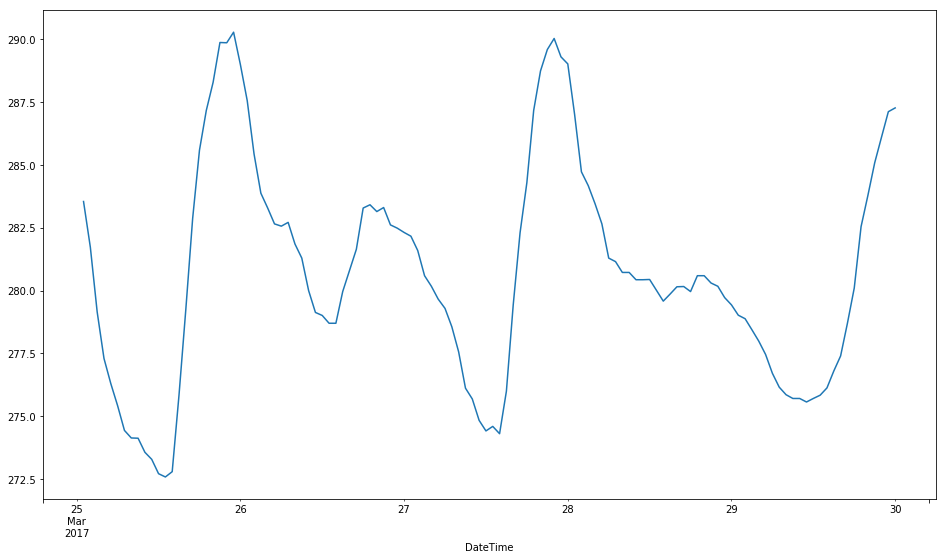

In [6]:
ts_ex = 'ts10'
df_ex = df.loc[:, ts_ex]

# Plot data from first five days
df_ex.iloc[:24*5].plot();

### Time Series Decomposition

Decompose the example time series into trend, seasonal, and residual components.

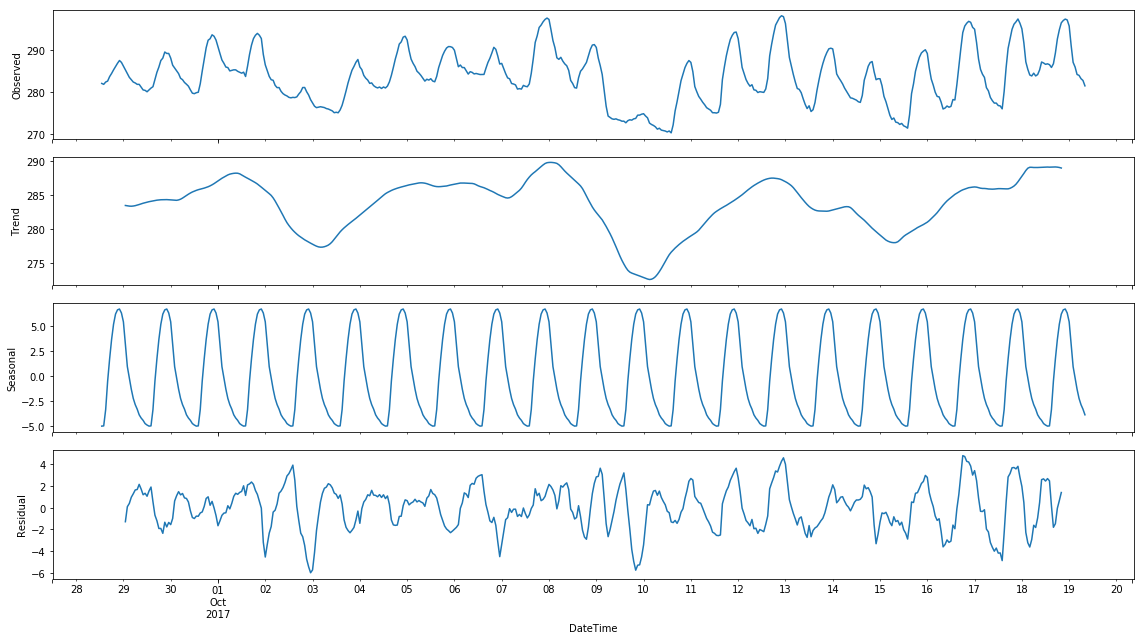

In [7]:
fig = seasonal_decompose(df_ex.iloc[-500:], model='additive').plot()

In [8]:
dftest = adfuller(df_ex.iloc[-500:], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  -1.771381
p-value                          0.394760
#Lags Used                      18.000000
Number of Observations Used    481.000000
Critical Value (1%)             -3.444018
Critical Value (10%)            -2.569980
Critical Value (5%)             -2.867568
dtype: float64

### Plot ACF and PACF

The <a href="https://en.wikipedia.org/wiki/Autocorrelation">Autocorrelation Function</a> (ACF) is the correlation of a signal with a delayed copy of itself as a function of delay.

The <a href="https://en.wikipedia.org/wiki/Partial_autocorrelation_function">Partial Autocorrelation Function</a> (PACF) is the partial correlation of a signal with a delayed copy of itself, controlling for the values of the time series at all shorter delays, as a function of delay.

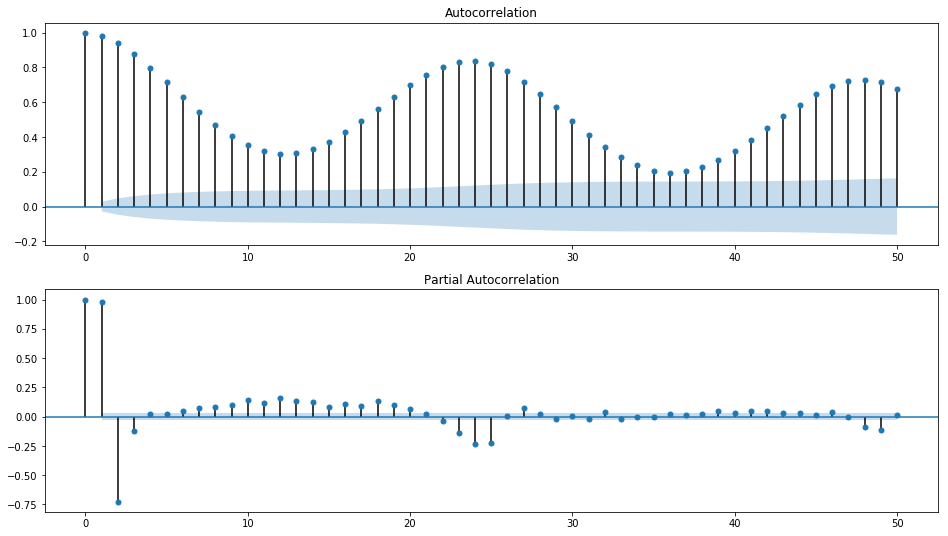

In [9]:
fig, ax = plt.subplots(2)
ax[0] = sm.graphics.tsa.plot_acf(df_ex, lags=50, ax=ax[0])
ax[1] = sm.graphics.tsa.plot_pacf(df_ex, lags=50, ax=ax[1])

There is clearly daily seasonality. A seasonality of 24 hours will be used for the SARIMAX model. Differencing by 24 hours helps remove the seasonality:

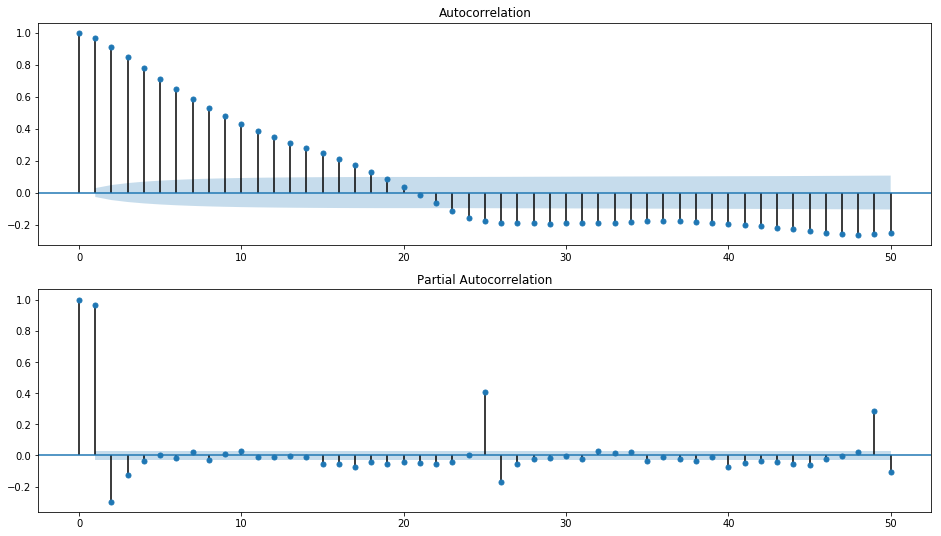

In [10]:
fig, ax = plt.subplots(2)
ax[0] = sm.graphics.tsa.plot_acf(df_ex.diff(24).dropna(), lags=50, ax=ax[0])
ax[1] = sm.graphics.tsa.plot_pacf(df_ex.diff(24).dropna(), lags=50, ax=ax[1])

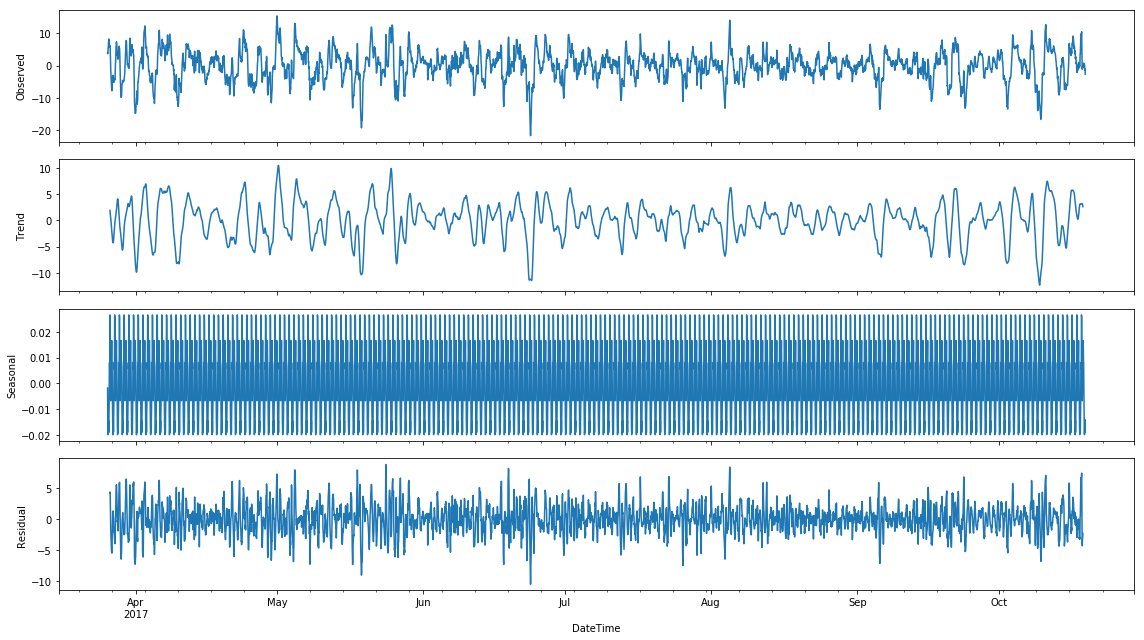

In [11]:
fig = seasonal_decompose(df_ex.diff(24).dropna(), model='additive').plot()

### Prepare Data

In [12]:
df_ex = pd.DataFrame(df_ex)
days = df_ex.index.dayofweek
dummy_days = pd.get_dummies(days)
dummy_days.columns = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
dummy_days.index = df_ex.index

df_ex = pd.concat([df_ex, dummy_days], axis=1)
df_ex.head()

,ts10,mon,tue,wed,thu,fri,sat,sun
DateTime,,,,,,,,
2017-03-25 01:00:00,283.54,0,0,0,0,0,1,0
2017-03-25 02:00:00,281.72,0,0,0,0,0,1,0
2017-03-25 03:00:00,279.15,0,0,0,0,0,1,0
2017-03-25 04:00:00,277.30,0,0,0,0,0,1,0
2017-03-25 05:00:00,276.30,0,0,0,0,0,1,0


### Build Model

As SARIMA models can be slow to train, a SARIMAX(1,1,1)(1,1,1)24 model will be used, as this should provide reasonable performance across the time series. Optimised forecasts could be obtained by using a grid search methodology to derive the best performining parameters, as demonstrated in the ARIMA and ARIMAX notebooks, but this would be at the expense of much greater training times.

In [13]:
def runSARIMAX(time_series, test_length=prediction_length, train_length=context_length):
    ts = time_series.iloc[-(test_length+train_length):]
    ts_train = ts.iloc[:-test_length]
    ts_test = ts.iloc[-test_length:]
    
    sarimax = sm.tsa.SARIMAX(endog=ts_train.iloc[:, 0],
                             exog=ts_train.iloc[:, 1:],
                             order=(1,1,1),
                             seasonal_order=(1,1,1,24),
                             enforce_stationarity=False,
                             enforce_invertibility=False).fit()
    
    summary = sarimax.summary()

    fcst = sarimax.predict(start=ts.index[2], end=ts.index[-1],
                           exog=ts_test.iloc[:, 1:])
    fcst = np.concatenate([np.array([0, 0]), fcst])
    fcst = pd.DataFrame(data=fcst, index=ts.index, columns=['pred%s' % ts.columns[0][2:]])
    
    return fcst, summary

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
%%time
fcst, summary = runSARIMAX(df_ex)
df_ex = pd.concat([df_ex, fcst], axis=1)
print(summary)

                                 Statespace Model Results                                 
Dep. Variable:                               ts10   No. Observations:                  672
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood                -698.800
Date:                            Sat, 13 Oct 2018   AIC                           1421.601
Time:                                    17:18:43   BIC                           1474.777
Sample:                                09-20-2017   HQIC                          1442.269
                                     - 10-18-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
mon           -0.1020   1.13e+05  -8.99e-07      1.000   -2.22e+05    2.22e+05
tue            0.1960   1.13e+05   

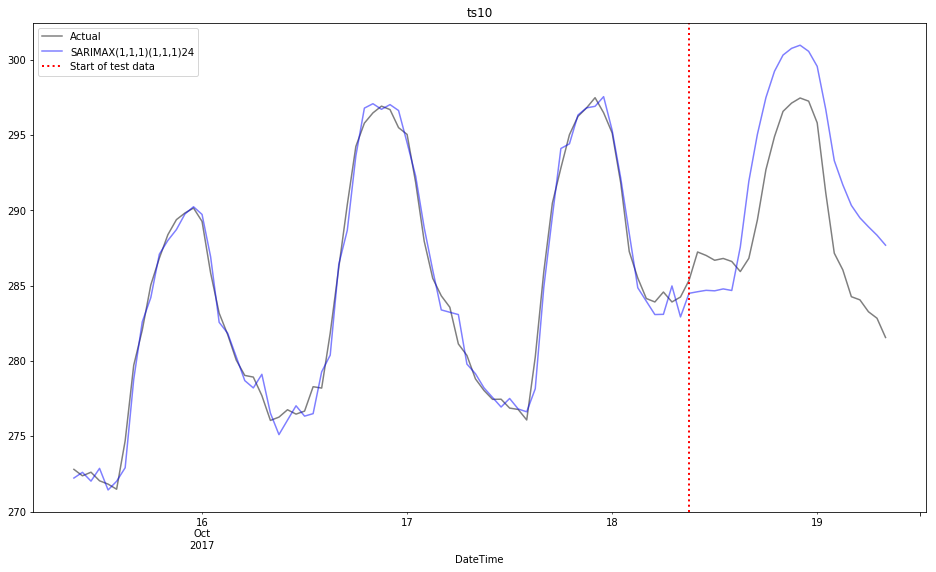

In [16]:
# Example forecast
fcst0 = df_ex.copy()
fcst0['pred%s' % ts_ex[2:]][fcst0['pred%s' % ts_ex[2:]] < 0] = 0

fcst0.iloc[-4*prediction_length:, 0].plot(label='Actual', c='k', alpha=0.5)
fcst0.iloc[-4*prediction_length:, -1].plot(label='SARIMAX(1,1,1)(1,1,1)24', c='b', alpha=0.5)
plt.axvline(x=fcst0.index[-prediction_length], linestyle=':', linewidth=2, color='r', label='Start of test data')
plt.legend()
plt.title(ts_ex);

## Evaluating SARIMAX

To evaluate SARIMAX, we will generate forecasts for each time series using the SARIMAX(1,1,1)(1,1,1)24 approach shown above. MASE and sMASE will be calculated for each individual time series, and the mean of all these scores will be used as overall accuracy metrics for SARIMAX on this dataset.

In [17]:
results = df.iloc[-(prediction_length+context_length):].copy()

tic = time()
for i, col in enumerate(df.columns):
    if i % 10 == 0:
        toc = time()
        print("Running predictions for {}. Cumulative time: {:.1f} minutes.".format(col, (toc-tic)/60))
        
    # Prepare DataFrame for selected column
    dft = df.loc[:, col]
    dft = pd.DataFrame(dft)
    days = dft.index.dayofweek
    dummy_days = pd.get_dummies(days)
    dummy_days.columns = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
    dummy_days.index = dft.index
    dft = pd.concat([dft, dummy_days], axis=1)
    
    # Find best model
    fcst, summary = runSARIMAX(dft)
    # Add predictions to results DataFrame
    results['pred%s' % col[2:]] = fcst.values

toc = time()
print("Finished! Total run time: {:.1f} minutes.".format((toc-tic)/60))

Running predictions for ts1. Cumulative time: 0.0 minutes.
Running predictions for ts11. Cumulative time: 3.8 minutes.
Running predictions for ts21. Cumulative time: 7.3 minutes.
Running predictions for ts31. Cumulative time: 11.4 minutes.
Finished! Total run time: 13.8 minutes.


In [18]:
results0 = results.copy()
results0[results0 < 0] = 0
results0.head()

,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,ts11,ts12,ts13,ts14,ts15,ts16,ts17,ts18,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28,ts29,ts30,ts31,ts32,ts33,ts34,ts35,ts36,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,pred10,pred11,pred12,pred13,pred14,pred15,pred16,pred17,pred18,pred19,pred20,pred21,pred22,pred23,pred24,pred25,pred26,pred27,pred28,pred29,pred30,pred31,pred32,pred33,pred34,pred35,pred36
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-09-20 09:00:00,284.15,285.44,288.86,282.14,291.22,293.40,295.79,297.20,290.79,279.24,298.52,299.72,299.15,297.49,294.15,294.71,290.42,292.63,291.93,293.45,292.15,295.31,291.32,299.40,289.01,291.37,294.40,294.73,289.82,291.61,302.302,301.71,305.17,300.96,301.08,301.76,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-09-20 10:00:00,283.38,284.86,288.23,282.04,291.15,293.14,294.97,296.00,288.97,279.47,298.40,299.09,298.93,297.48,293.87,294.14,290.43,292.41,291.93,292.85,291.81,294.88,291.04,298.43,288.66,291.11,293.82,294.88,289.12,291.77,302.302,302.15,306.66,301.55,301.62,302.15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-09-20 11:00:00,283.38,284.72,289.14,282.13,290.91,293.23,294.13,295.80,288.92,279.36,298.52,299.03,299.03,296.48,294.30,294.00,290.34,292.39,292.15,292.55,291.48,294.61,290.95,298.89,288.49,290.87,293.65,294.88,289.79,291.65,303.740,302.59,308.66,302.56,302.62,302.54,295.390431,302.203390,321.853580,299.348076,308.621339,309.743411,300.635390,298.794738,298.100704,296.219283,316.560087,316.668542,314.069157,318.706568,305.613493,311.126293,307.547192,310.039540,309.743685,311.059578,307.849222,312.023668,303.908540,298.436326,308.392195,305.318900,310.773534,312.500271,297.290914,312.187814,302.321689,331.265380,308.103211,320.988155,320.737863,332.200828
2017-09-20 12:00:00,283.12,284.30,288.73,282.55,290.48,293.23,294.13,294.98,287.43,279.70,298.53,298.33,298.48,296.34,294.00,293.70,290.94,292.34,291.58,292.33,291.82,294.72,291.05,298.77,289.15,290.52,293.90,294.98,290.84,291.90,303.740,302.59,309.15,303.15,303.15,302.54,286.343743,289.701939,302.248307,287.180242,295.841648,297.914335,293.339238,295.501805,290.895897,284.116196,303.814850,304.031130,303.096078,302.644319,297.223231,298.761249,295.177928,297.462803,297.372982,297.773642,295.805017,299.384833,294.147755,298.888274,294.426110,294.517102,298.390406,299.919898,291.606242,297.852554,303.754410,312.936906,308.939067,308.662943,308.581528,313.319353
2017-09-20 13:00:00,282.90,284.43,289.05,282.53,290.90,292.57,293.47,294.71,286.18,279.38,298.77,298.34,298.92,296.14,293.49,294.54,291.69,293.93,292.16,292.77,292.60,296.31,294.41,299.27,290.99,291.65,294.60,295.88,291.81,292.31,303.740,303.15,309.64,303.15,303.15,303.15,283.778124,285.597392,293.403263,284.166864,291.746620,294.544887,294.260993,295.111400,287.499680,281.183040,300.067352,299.516108,299.391119,298.193706,294.617322,294.946626,292.526926,293.786333,292.888077,293.782396,293.130954,296.116212,291.880957,298.770451,291.213800,291.368343,295.330206,296.458867,291.445325,293.899616,303.740142,306.198500,309.212378,305.169301,305.091041,306.344987


In [19]:
sMASEs = []
for i, col in enumerate(df.columns):
    sMASEs.append(calc_sMASE(results0[col].iloc[-(context_length + prediction_length):-prediction_length],
                             results0[col].iloc[-prediction_length:],
                             results0['pred%s' % str(i+1)].iloc[-prediction_length:]))

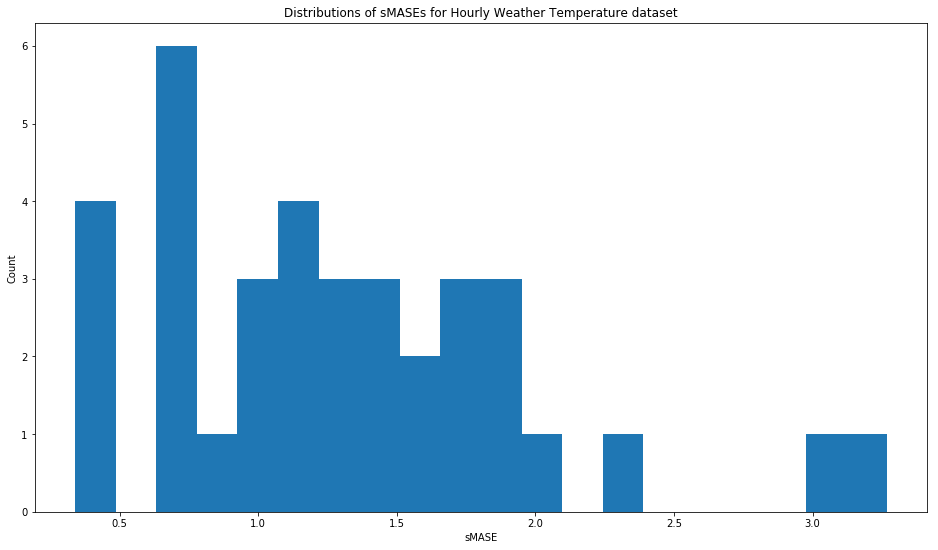

In [20]:
fig, ax = plt.subplots()
ax.hist(sMASEs, bins=20)
ax.set_title('Distributions of sMASEs for {} dataset'.format(dataset_name))
ax.set_xlabel('sMASE')
ax.set_ylabel('Count');

In [21]:
sMASE = np.mean(sMASEs)
print("Overall sMASE: {:.4f}".format(sMASE))

Overall sMASE: 1.3084


Show some example forecasts.

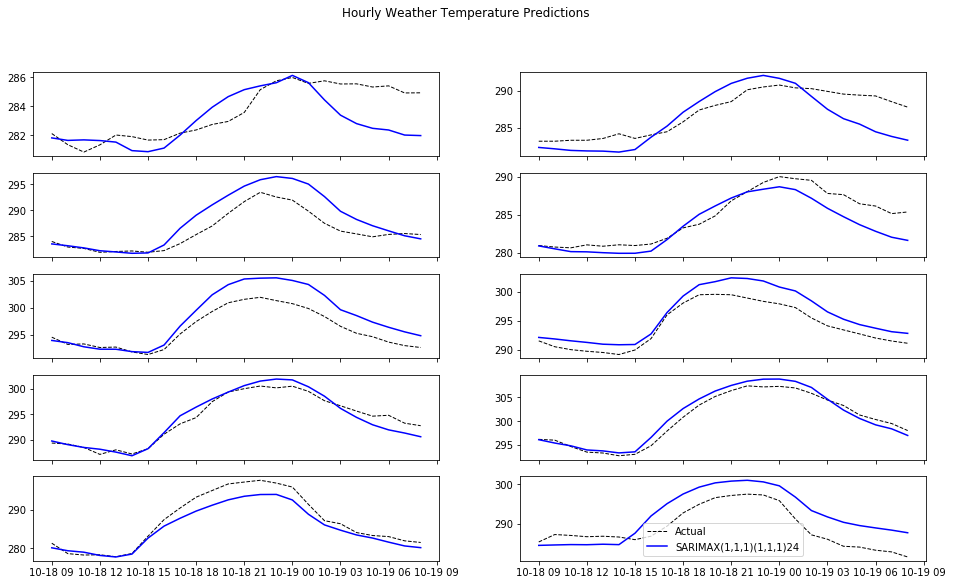

In [22]:
fig, ax = plt.subplots(5, 2, sharex=True)
ax = ax.ravel()

for col in range(1, 11):
    ax[col-1].plot(results0.index[-prediction_length:], results0['ts%s' % col].iloc[-prediction_length:],
                   label='Actual', c='k', linestyle='--', linewidth=1)
    ax[col-1].plot(results0.index[-prediction_length:], results0['pred%s' % col].iloc[-prediction_length:],
                   label='SARIMAX(1,1,1)(1,1,1)24', c='b')
ax[9].legend()
fig.suptitle('{} Predictions'.format(dataset_name));

Store the predictions and accuracy score for the SARIMAX models.

In [23]:
import pickle
    
with open('{}-sMASE.pkl'.format(dataset_abbr), 'wb') as f:
    pickle.dump(sMASE, f)
    
with open('../_results/{}/{}-results.pkl'.format(model_name, dataset_abbr), 'wb') as f:
    pickle.dump(results.iloc[-prediction_length:], f)